In [1]:
import sqlite3                   # data is stored in a sql table
from sqlite3 import Error
import csv                       # I first tried to get data in json but had some problems to load, so I used csv
import json
import requests                  # to get the data from the Chicago site
import pandas as pd              # get a better view of the info (sqlite is not very friendly)
from datetime import datetime
import time

import os                        # to manage files in hard drive

import matplotlib.pyplot as plt

In [2]:
#url = 'https://data.cityofchicago.org/resource/m6dm-c72p.json?$$app_token=jgQqhL8MrkDPkmBlNFolO6a13&$where=trip_start_timestamp%20%3E=%20%272021-01-01T00:00:00%27&$limit=1000'
#print(url)
#content = requests.get(url).content
#dataset = json.loads(content)
#print(len(dataset))
#print(dataset[0])

### Create sqlite database and set connection

#### database is created in the same directory of the notebook

In [3]:
connection = sqlite3.connect("chicago.sqlite") #, isolation_level=None) # change to 'sqlite:///your_filename.db'
cur = connection.cursor()

### Create table for the raw data from Chicago site.




In [4]:
# connection.execute("DROP TABLE IF EXISTS trips_csv;")

cur.execute("""CREATE TABLE trips_csv(trip_id TEXT, 
                                      trip_start_timestamp TEXT, 
                                     trip_end_timestamp TEXT, 
                                      trip_seconds REAL, 
                                      trip_miles REAL, 
                                      pickup_census_tract TEXT NULL, 
                                      dropoff_census_tract TEXT NULL, 
                                      pickup_community_area INTEGER, 
                                      dropoff_community_area INTEGER, 
                                      fare REAL, 
                                      tip REAL, 
                                      additional_charges REAL, 
                                      trip_total REAL, 
                                      shared_trip_authorized TEXT, 
                                      trips_pooled REAL,
                                      pickup_centroid_latitude TEXT, 
                                      pickup_centroid_longitude TEXT, 
                                      pickup_centroid_location TEXT, 
                                      dropoff_centroid_latitude TEXT, 
                                      dropoff_centroid_longitude TEXT, 
                                      dropoff_centroid_location TEXT);
            """) # use your column names here



### Retrieve data from Chicago Site in CSV format

Data is retrieved using SOCRATA API month by month, trying to get all the data in one shot or in larger chunks consume a lot of RAM and makes the pc unresponsive.

After the request, data is inserted in the SQLite table created above





In [5]:
# link to the trips database

url_completa = '&$where=date_extract_y(trip_start_timestamp)=2020%20and%20date_extract_m(trip_start_timestamp)=1'

main = 'https://data.cityofchicago.org/resource/m6dm-c72p.csv?'

token = '$$app_token=TEOwHbkd1vVtNleSBB7y8V7GA'

#yer
condition_a = '&$where=date_extract_y(trip_start_timestamp)='

#month
condition_b = '%20and%20date_extract_m(trip_start_timestamp)='

#limit set too high to ensure all data is retrieved
limit = '&$limit=100000000'

inicio = datetime.now()

print("inicio_todo =", inicio)

for y in [2018,2019,2020,2021]:
    for m in range(1,13):
        
        # this if is to skip months that do not have data, each query even if there is no info can take 5 minutes.
        
        if (y == 2018 and m < 11) or (y == 2021 and m > 1):
            continue

        # request to he site using the complete url
        
        url_csv = main + token + condition_a + str(y) + condition_b + str(m) + limit

        start = datetime.now()

        print("start_request =", y, m,start)

        file_csv = requests.get(url_csv).text

        end = datetime.now()

    #    print("end_request =", y,m, end)

        print("time_request", y,m, end - start)

        # split retrieved info into rows at each "\n"

        start = datetime.now()

    #    print("start_csv =", y,m, start)

        lines = file_csv.splitlines()

        # convert the info to CSV

        reader = csv.reader(lines)
        next(reader)


        end = datetime.now()

    #    print("end_csv =", y,m, end)

        print("time_csv", y,m, end - start)

        # Inster each row into trips table (skipping the header line), show the first two records after the header line

        # Insert CSV into sqlite

        start = datetime.now()

    #    print("start_insert =", y,m, start)


        cur.executemany("INSERT INTO trips_csv VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", reader)
        
        connection.commit()

        end = datetime.now()

    #    print("end_insert =", i, end)

        print("time_insert", y,m, end - start)

        del reader
        
fin = datetime.now()

#print("inicio_todo =", inicio)

print("tiempo_todo =", fin - inicio)




inicio_todo = 2021-04-01 21:54:41.007611
start_request = 2018 11 2021-04-01 21:54:41.012692
time_request 2018 11 0:09:31.910531
time_csv 2018 11 0:00:05.272208
time_insert 2018 11 0:01:29.214840
start_request = 2018 12 2021-04-01 22:05:47.411671
time_request 2018 12 0:08:35.780520
time_csv 2018 12 0:00:14.934282
time_insert 2018 12 0:01:30.495727
start_request = 2019 1 2021-04-01 22:16:08.624612
time_request 2019 1 0:10:01.772189
time_csv 2019 1 0:00:09.799007
time_insert 2019 1 0:01:31.936296
start_request = 2019 2 2021-04-01 22:27:52.133020
time_request 2019 2 0:09:13.769568
time_csv 2019 2 0:00:10.781448
time_insert 2019 2 0:01:30.480725
start_request = 2019 3 2021-04-01 22:38:47.165646
time_request 2019 3 0:09:28.069897
time_csv 2019 3 0:00:13.624655
time_insert 2019 3 0:01:46.360815
start_request = 2019 4 2021-04-01 22:50:15.228097
time_request 2019 4 0:10:26.215887
time_csv 2019 4 0:00:20.131672
time_insert 2019 4 0:01:31.646114
start_request = 2019 5 2021-04-01 23:02:33.224125
t

### check number of rows retrieved

In [6]:
start = datetime.now()
print("start_query =", start)


sql = "SELECT count(*) FROM trips_csv;"
cursor = connection.execute(sql)

print(cursor.fetchall()[0][0])

end = datetime.now()
print("end_query =", end)

start_query = 2021-04-02 02:00:45.237299
182673447
end_query = 2021-04-02 02:05:40.881859


### first rows

In [7]:
start = datetime.now()
print("start_query =", start)


sql = "SELECT * FROM trips_csv LIMIT 20;"
#cursor = connection.execute(sql)
#print(cursor.fetchall())

df_summary_view = pd.read_sql_query(sql, connection)


end = datetime.now()
print("end_query =", end)

df_summary_view.head()

start_query = 2021-04-02 02:05:40.890759
end_query = 2021-04-02 02:05:41.442689


,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,additional_charges,trip_total,shared_trip_authorized,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,5815db4a25c8994709353c70994b072e48385464,2018-11-23T17:15:00.000,2018-11-23T17:45:00.000,1950.0,14.373830,,17031839100,,32,22.5,...,2.92,25.42,false,1.0,,,,41.8809944707,-87.6327464887,POINT (-87.6327464887 41.8809944707)
1,5816b8f5a27fac172efcecca499b7684c11867c8,2018-11-12T09:30:00.000,2018-11-12T09:45:00.000,754.0,2.297425,,,44,45,7.5,...,2.50,10.00,false,1.0,41.7402057565,-87.6159695226,POINT (-87.6159695226 41.7402057565),41.7441995348,-87.5863483178,POINT (-87.5863483178 41.7441995348)
2,5816ff10e7ec7572533bbbcdf82187f0223a3f29,2018-11-27T15:00:00.000,2018-11-27T15:45:00.000,3308.0,16.500992,,17031980000,,76,30.0,...,7.50,37.50,false,1.0,,,,41.9790708201,-87.9030396611,POINT (-87.9030396611 41.9790708201)
3,58188003c0600adcfd7d2a0d87e56dd1f1a646ff,2018-11-30T19:00:00.000,2018-11-30T19:30:00.000,1656.0,6.405921,,17031230900,,23,5.0,...,2.50,7.50,true,4.0,,,,41.9066839592,-87.7103539349,POINT (-87.7103539349 41.9066839592)
4,5818b241883c5a9049ae22373eb93dc4d5c47667,2018-11-13T15:30:00.000,2018-11-13T16:15:00.000,2314.0,10.416654,17031839100,,32,,12.5,...,2.50,15.00,true,2.0,41.8809944707,-87.6327464887,POINT (-87.6327464887 41.8809944707),,,


## Create summary table table:

- trip startdate (yyyy-mm-dd)
- year (2018...)
- month (1..12),
- week of year (1..55),
- day of year (1..366),
- day of week (Sunday, Monday.....)
- hour of day (0..23)
- pickup community area
- pickup centroid location
- COUNT of trips
- SUM of trip seconds
- SUM of trip miles
- Sum of fare
- Sum of tip
- Sum of additional charges
- Sum of total 



In [8]:

start = datetime.now()
print("start_query =", start)


# connection.execute("DROP TABLE IF EXISTS trips_summary;")


sql = """CREATE TABLE trips_summary AS
            SELECT strftime('%Y-%m-%d',trip_start_timestamp) as date,
                CAST(strftime('%Y',trip_start_timestamp) AS INTEGER) as year,
                CAST(strftime('%m',trip_start_timestamp) AS INTEGER) as month,
                CAST(strftime('%W',trip_start_timestamp) AS INTEGER) as week_year,
                CAST(strftime('%j',trip_start_timestamp) AS INTEGER) as day_year,
                case cast (strftime('%w', trip_start_timestamp) as integer)
                  when 0 then 'Sunday'
                  when 1 then 'Monday'
                  when 2 then 'Tuesday'
                  when 3 then 'Wednesday'
                  when 4 then 'Thursday'
                  when 5 then 'Friday'
                  else 'Saturday' end as week_day,
                CAST(strftime('%H',trip_start_timestamp) AS INTEGER) as hour,
                pickup_community_area,
                count(*) as count,
                sum(trip_seconds) as trip_seconds_tot,
                sum(trip_miles) as trip_miles_tot,
                sum(fare) as fare_tot, 
                sum(tip) as tip_tot, 
                sum(additional_charges) additional_tot, 
                sum(trip_total) trip_total_tot,
                sum(fare+tip) as total_revenue                
            FROM trips_csv
            WHERE fare > 0
                  AND pickup_community_area <> ''
                  AND trip_total > 0
            GROUP BY 1,2,3,4,5,6,7,8;"""
cursor = connection.execute(sql)

connection.commit()

end = datetime.now()
print("end_query =", end)

print("time_query =", end - start)

os.system('say "your process has finished"')

start_query = 2021-04-02 02:05:41.503604
end_query = 2021-04-02 03:07:38.650652
time_query = 1:01:57.147048


0

In [9]:
# view firs columns

sql = """SELECT *
            FROM trips_summary
            Limit 10
      ;"""

#cursor = connection.execute(sql)

#print(cursor.fetchall())

df_summary_view = pd.read_sql_query(sql, connection)
df_summary_view

,date,year,month,week_year,day_year,week_day,hour,pickup_community_area,count,trip_seconds_tot,trip_miles_tot,fare_tot,tip_tot,additional_tot,trip_total_tot,total_revenue
0,2018-11-01,2018,11,44,305,Thursday,0,1,74,58767.0,398.706782,715.0,44.0,166.70,925.70,759.0
1,2018-11-01,2018,11,44,305,Thursday,0,2,33,22450.0,126.391116,230.0,4.0,80.21,314.21,234.0
2,2018-11-01,2018,11,44,305,Thursday,0,3,219,173141.0,1109.903238,2102.5,131.0,525.87,2759.37,2233.5
3,2018-11-01,2018,11,44,305,Thursday,0,4,61,50194.0,308.281846,550.0,28.0,142.50,720.50,578.0
4,2018-11-01,2018,11,44,305,Thursday,0,5,87,61894.0,311.618548,655.0,42.0,191.27,888.27,697.0
5,2018-11-01,2018,11,44,305,Thursday,0,6,795,603114.0,3291.116724,6460.0,249.0,1803.82,8512.82,6709.0
6,2018-11-01,2018,11,44,305,Thursday,0,7,500,405165.0,2379.158014,4567.5,162.0,1153.06,5882.56,4729.5
7,2018-11-01,2018,11,44,305,Thursday,0,8,1111,838561.0,5467.693400,9857.5,306.0,2609.41,12772.91,10163.5
8,2018-11-01,2018,11,44,305,Thursday,0,9,10,5274.0,30.222446,67.5,1.0,25.30,93.80,68.5
9,2018-11-01,2018,11,44,305,Thursday,0,10,17,11796.0,102.511850,172.5,4.0,43.45,219.95,176.5


### export summary to CSV

In [10]:
sql = """SELECT *
            FROM trips_summary
      ;"""

cursor = connection.execute(sql)

tabla = cursor.fetchall()

tabla[0:2]

[('2018-11-01',
  2018,
  11,
  44,
  305,
  'Thursday',
  0,
  1,
  74,
  58767.0,
  398.7067818855732,
  715.0,
  44.0,
  166.7,
  925.7,
  759.0),
 ('2018-11-01',
  2018,
  11,
  44,
  305,
  'Thursday',
  0,
  2,
  33,
  22450.0,
  126.39111570613902,
  230.0,
  4.0,
  80.21,
  314.21,
  234.0)]

In [11]:
#EXPORT TO CSV normal

names = [description[0] for description in cursor.description]


if os.path.exists("trips_summary_sql.csv"):
    os.remove("trips_summary_sql.csv")
    
with open('trips_summary_sql.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(names)
    for row in tabla:
        csv_out.writerow(row)    

In [12]:
#EXPORT TO CSV pandas

df_summary = pd.read_sql_query(sql, connection)


df_summary.to_csv('trips_summary_pandas.csv',index=False)

### Count of lines in summary table

In [13]:
# count summary_trips

start = datetime.now()
print("start_query =", start)


sql = """SELECT count(*)
            FROM trips_summary
      ;"""
cursor = connection.execute(sql)

end = datetime.now()
print("end_query =", end)

cursor.fetchall()



start_query = 2021-04-02 03:08:29.065949
end_query = 2021-04-02 03:08:29.164569


[(1510900,)]

### basic plots

In [14]:
sql = """SELECT substr(date,1,7) as month_l, sum(count) as count, sum(total_revenue) as revenue
            FROM trips_summary
            GROUP BY 1
      ;"""

#cursor = connection.execute(sql)

#print(cursor.fetchall())

df_month_trip_revenue = pd.read_sql_query(sql, connection, index_col=None)
df_month_trip_revenue

,month_l,count,revenue
0,2018-11,8156754,90564414.5
1,2018-12,8081580,86984598.0
2,2019-01,8196037,85161516.0
3,2019-02,8217412,88159710.5
4,2019-03,9536327,104421330.5
5,2019-04,8548580,101957966.0
6,2019-05,8997097,115196219.5
7,2019-06,8830256,117303700.0
8,2019-07,8494306,101018333.0
9,2019-08,8740617,104779122.0


<AxesSubplot:xlabel='month_l'>

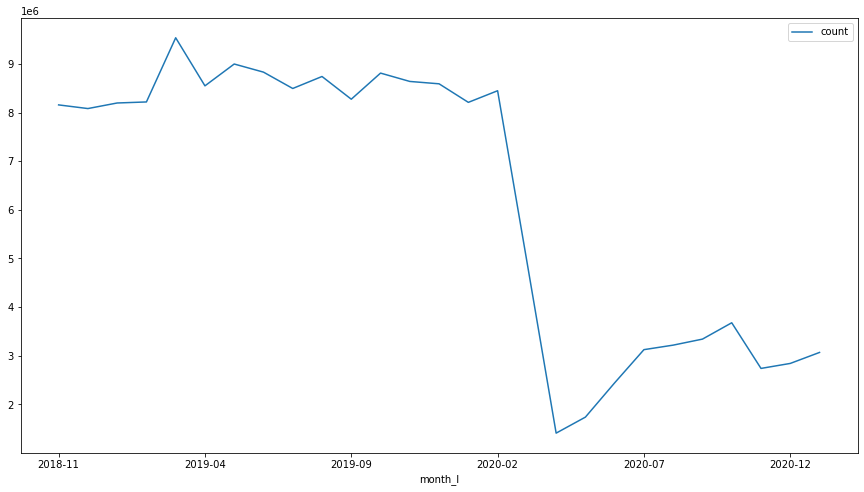

In [15]:
df_month_trip_revenue.plot(x='month_l', y='count', figsize=(15,8))


<AxesSubplot:xlabel='month_l'>

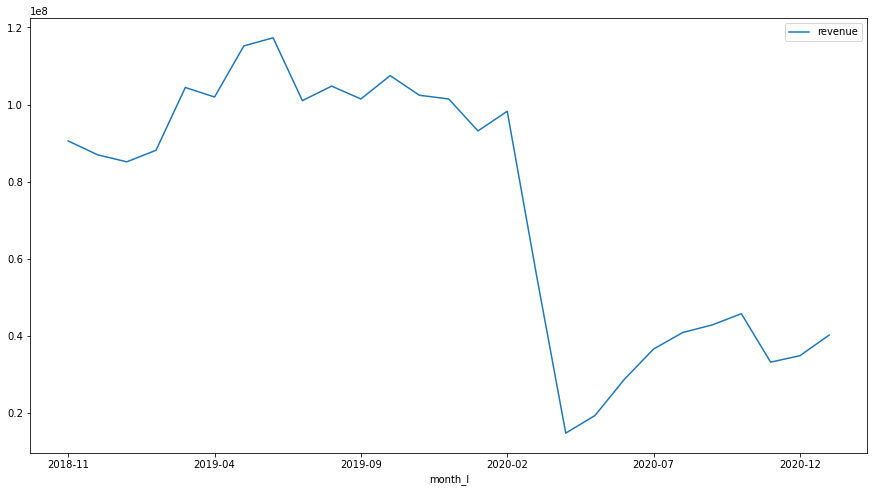

In [16]:
df_month_trip_revenue.plot(x='month_l', y='revenue', figsize=(15,8))

### community areas (pickup) and trips

In [17]:
#COUNT pickup_community_area

sql = """SELECT pickup_community_area, sum(count) as trips
            from trips_summary
            Group by 1
            order by 2 DESC

      ;"""
#cursor = connection.execute(sql)

#cursor.fetchall()

df_comm_area = pd.read_sql_query(sql, connection)
df_comm_area[0:]

,pickup_community_area,trips
0,8,27892354
1,32,14857048
2,28,14824405
3,6,11692002
4,24,10784580
...,...,...
72,74,153915
73,54,149621
74,52,94721
75,47,81531


<AxesSubplot:xlabel='pickup_community_area'>

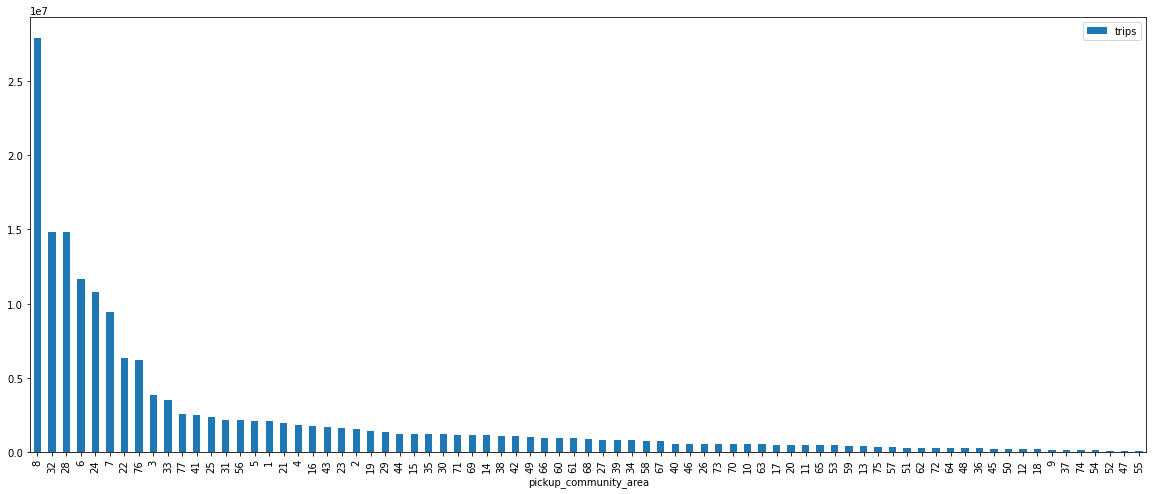

In [18]:
df_comm_area.plot.bar(x='pickup_community_area', y='trips', figsize=(20,8))

In [19]:
#january 2021 summary

sql = """SELECT date, pickup_community_area, hour, sum(count) as trips, sum(total_revenue) as revenue, sum(total_revenue)/sum(count) as avg_revenue
            from trips_summary
            where year = 2021 and
                  month = 01      
            Group by 1,2,3
      ;"""
#cursor = connection.execute(sql)

#cursor.fetchall()

df_dummy = pd.read_sql_query(sql, connection)
df_dummy.head()

,date,pickup_community_area,hour,trips,revenue,avg_revenue
0,2021-01-01,1,0,80,1078.0,13.475000
1,2021-01-01,1,1,101,2288.0,22.653465
2,2021-01-01,1,2,77,2098.0,27.246753
3,2021-01-01,1,3,81,2115.0,26.111111
4,2021-01-01,1,4,47,977.0,20.787234


In [20]:
df_dummy.to_csv('trips_dummy_january.csv',index=False)

### get the name of the tables that are in the database

In [21]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('trips_csv',), ('trips_summary',)]


### get the schema of the Trips table

In [22]:
#table info

cur.execute("pragma table_info('trips_csv');")
print(cur.fetchall())



[(0, 'trip_id', 'TEXT', 0, None, 0), (1, 'trip_start_timestamp', 'TEXT', 0, None, 0), (2, 'trip_end_timestamp', 'TEXT', 0, None, 0), (3, 'trip_seconds', 'REAL', 0, None, 0), (4, 'trip_miles', 'REAL', 0, None, 0), (5, 'pickup_census_tract', 'TEXT', 0, None, 0), (6, 'dropoff_census_tract', 'TEXT', 0, None, 0), (7, 'pickup_community_area', 'INTEGER', 0, None, 0), (8, 'dropoff_community_area', 'INTEGER', 0, None, 0), (9, 'fare', 'REAL', 0, None, 0), (10, 'tip', 'REAL', 0, None, 0), (11, 'additional_charges', 'REAL', 0, None, 0), (12, 'trip_total', 'REAL', 0, None, 0), (13, 'shared_trip_authorized', 'TEXT', 0, None, 0), (14, 'trips_pooled', 'REAL', 0, None, 0), (15, 'pickup_centroid_latitude', 'TEXT', 0, None, 0), (16, 'pickup_centroid_longitude', 'TEXT', 0, None, 0), (17, 'pickup_centroid_location', 'TEXT', 0, None, 0), (18, 'dropoff_centroid_latitude', 'TEXT', 0, None, 0), (19, 'dropoff_centroid_longitude', 'TEXT', 0, None, 0), (20, 'dropoff_centroid_location', 'TEXT', 0, None, 0)]


### A failed attempt to use another method to retrieve the information from the Chicago Site.


#### This method is recommended in the site but did not work, I got time-out errors all the time 

In [23]:
#client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
#client = Socrata("data.cityofchicago.org", None)
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
#results = client.get("m6dm-c72p", limit=500)

                  
                  
# Convert to pandas DataFrame
#results_df = pd.DataFrame.from_records(results)

### Close connection to database

In [24]:
connection.close()

In [25]:
print('hola')

hola
